In [37]:
# 한번만 하면 됌
import os

# 원본 데이터 저장 폴더
os.makedirs("./content/data/raw/1", exist_ok=True)
os.makedirs("./content/data/raw/2", exist_ok=True)

# 전처리 후 저장 폴더
os.makedirs("./content/data/processed/train/1", exist_ok=True)
os.makedirs("./content/data/processed/train/2", exist_ok=True)
os.makedirs("./content/data/processed/val/1", exist_ok=True)
os.makedirs("./content/data/processed/val/2", exist_ok=True)
os.makedirs("./content/data/processed/test/1", exist_ok=True)
os.makedirs("./content/data/processed/test/2", exist_ok=True)

In [35]:
import random
from PIL import Image

RAW = "./content/data/raw" #처리 전 데이터 위치
OUT = "./content/data/processed" #전처리 데이터 위치
CLASSES = ["1","2"] #클래스 2개
SIZE = (8, 8) #모델 간소화를 위해 이미지 축소
SPLIT_TRAIN = 0.7 #학습 데이터 총 32장
SPLIT_VAL = 0.2 #검증 테스트 데이터 각각 총 4장

def process_one(src, dst_dir): # 사진 한장 한장 흑백, 사이즈 축소하는 함수
    img = Image.open(src).convert("L").resize(SIZE)  # 흑백(L)으로 변경 및 축소
    img.save(os.path.join(dst_dir, os.path.basename(src))) # 파일명만 가져와서 dst_dir에 저장

def preprocess():
    total = 0 # 전처리된 이미지 카운트
    for c in CLASSES: # 클래스 별 전처리
        src_dir = os.path.join(RAW, c) # 처리 전 데이터 위치 저장
        files = [f for f in os.listdir(src_dir)] # 처리 전 데이터 파일명 리스트에 저장
        random.shuffle(files) # train/val/test로 나누기 위해 섞기

        n_total = len(files) # train/val/test로 나누기 위해 전체 파일 수 카운트
        n_train = int(n_total * SPLIT_TRAIN) # 각각 비율대로 나눌 파일 수 정수로 저장
        n_val = int(n_total * SPLIT_VAL)
        n_test = n_total - n_train - n_val

        train_files = files[:n_train] # 각각 나누기
        val_files = files[n_train:n_train+n_val]
        test_files = files[n_train+n_val:]

        for f in train_files: #  process_one를 이용해서 processed 파일에 전처리 후 저장
            process_one(os.path.join(src_dir, f), os.path.join(OUT, "train", c))
        for f in val_files:
            process_one(os.path.join(src_dir, f), os.path.join(OUT, "val", c))
        for f in test_files:
            process_one(os.path.join(src_dir, f), os.path.join(OUT, "test", c))

        total += n_total

    print(f"전처리 완료! 총 {total}장 → train:{SPLIT_TRAIN*100:.0f}%, val:{SPLIT_VAL*100:.0f}%, test:{(1-SPLIT_TRAIN-SPLIT_VAL)*100:.0f}%")

preprocess()

전처리 완료! 총 40장 → train:70%, val:20%, test:10%


In [39]:
import os, random, shutil

RAW = "./content/data/raw"
OUT = "./content/data/processed"
CLASSES = ["1","2"]


def preprocess_pure(image_path, size=(64,64), invert=True, return_flat=False):
    """
    numpy 없이 순수 Python/PIL만 사용한 전처리:
    1) 이미지 읽기
    2) 흑백 변환
    3) 리사이즈
    4) 이진화(고정 threshold)
    5) 반전
    6) 표준화(0~1)
    """
    # 1. 이미지 로드 & 그레이스케일 변환
    img = Image.open(image_path).convert("L")

    # 2. 리사이즈
    img = img.resize(size, Image.Resampling.LANCZOS)

    # 3. 픽셀 데이터 읽기 (리스트)
    pixels = list(img.getdata())

    # 4. 이진화 (threshold=128)
    binary_pixels = [255 if p > 128 else 0 for p in pixels]

    # 5. 반전 옵션
    if invert:
        binary_pixels = [255 - p for p in binary_pixels]

    # 6. 표준화 (0~1 부동소수점 변환)
    normalized_pixels = [p / 255.0 for p in binary_pixels]

    # 7. 평탄화 여부
    if return_flat:
        return normalized_pixels
    else:
        # 2D 이미지 형태로 변환
        w, h = size
        rows = [normalized_pixels[i*w:(i+1)*w] for i in range(h)]
        return rows


def preprocess_dataset(size=(64,64), train_split=0.7, val_split=0.2, invert=True, clean=True):
    # 기존 processed 폴더 비우기
    if clean and os.path.isdir(OUT):
        shutil.rmtree(OUT)
    for split in ["train","val","test"]:
        for c in CLASSES:
            os.makedirs(os.path.join(OUT, split, c), exist_ok=True)

    total = 0
    for c in CLASSES:
        src_dir = os.path.join(RAW, c)
        files = [f for f in os.listdir(src_dir) if f.lower().endswith((".png",".jpg",".jpeg"))]
        random.shuffle(files)
        n = len(files)
        n_tr = int(n*train_split)
        n_va = int(n*val_split)
        tr, va, te = files[:n_tr], files[n_tr:n_tr+n_va], files[n_tr+n_va:]

        for split, group in [("train",tr), ("val",va), ("test",te)]:
            for fn in group:
                src_path = os.path.join(src_dir, fn)
                processed_img = preprocess_pure(src_path, size=size, invert=invert, return_flat=False)
                # PIL Image로 저장
                img_out = Image.new("L", size)
                img_out.putdata([int(p*255) for row in processed_img for p in row])
                img_out.save(os.path.join(OUT, split, c, os.path.splitext(fn)[0] + ".png"))
        total += n
    print(f"총 {total}장 전처리 완료 → {size}로 리사이즈 & 이진화 & 표준화")

preprocess_dataset(size=(64,64), invert=True)

총 40장 전처리 완료 → (64, 64)로 리사이즈 & 이진화 & 표준화


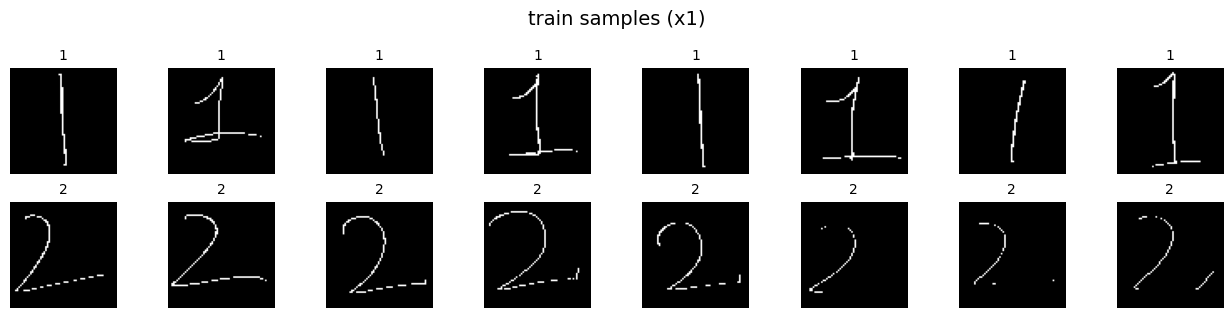

In [40]:
import math
import matplotlib.pyplot as plt

BASE = "./content/data/processed"
SPLIT = "train"          # "train" / "val" / "test"
CLASSES = ["1","2"]
N_PER_CLASS = 8          # 클래스별 몇 장 볼지
SCALE = 1               # 확대 배율

def pick_files(folder, n):
    fs = [f for f in os.listdir(folder)]
    return fs[:n]

# 파일 모으기
grid = []
for c in CLASSES:
    folder = f"{BASE}/{SPLIT}/{c}"
    files = pick_files(folder, N_PER_CLASS)
    grid.append([(c, os.path.join(folder, f)) for f in files])

# 그림판
rows = len(CLASSES)
cols = max(len(row) for row in grid) if grid else 0
plt.figure(figsize=(cols*1.6, rows*1.6))

idx = 1
for r, row in enumerate(grid):
    for c_label, path in row:
        img = Image.open(path).convert("L")
        big = img.resize((img.width*SCALE, img.height*SCALE), Image.NEAREST)
        ax = plt.subplot(rows, cols, idx)
        ax.imshow(big, cmap="gray", vmin=0, vmax=255)
        ax.set_title(f"{c_label}", fontsize=10)
        ax.axis("off")
        idx += 1
    # 빈 칸 채우기(열 수 맞추기)
    while idx <= (r+1)*cols:
        ax = plt.subplot(rows, cols, idx)
        ax.axis("off")
        idx += 1

plt.suptitle(f"{SPLIT} samples (x{SCALE})", fontsize=14)
plt.tight_layout()
plt.show()

In [41]:
BASE = "./content/data/processed"
POS_LABEL = "1"  # '1'은 1로 인덱싱
NEG_LABEL = "2"  # '2'는 0으로 인덱싱

random.seed(42)

def flatten8x8(img): # 이미지를 64의 1차원 피처로 변환하는 함수
    #return [p/255.0 for p in img.getdata()]  # getdata가 이미지 픽셀 각각 피처를 리스트로 변환
    return [(p/255.0) - 0.5 for p in img.getdata()]
    #return [ (p-(255/2))/255 for p in img.getdata()]

def load_split(split): # split(train, val, test 중 하나)에 해당하는 데이터들의 피처, 인덱스, (정답라벨문자, 파일명) 리스트 저장 함수
    X, y, names = [], [], [] # 각 이미지의 피처, 인덱스, (정답라벨문자, 파일명)
    for c in [POS_LABEL, NEG_LABEL]:
        d = os.path.join(BASE, split, c) # 전처리 데이터 주소 저장
        for fn in os.listdir(d): # 전처리 데이터 파일명 리스트로 저장
          X.append(flatten8x8(img)) # X에 flatten된 피처 저장
          y.append(1 if c==POS_LABEL else 0) # Y에 사전에 정한 인덱싱 값 저장
          names.append((c, fn))  # (정답라벨문자, 파일명)
    return X, y, names

Xtr, ytr, names_tr      = load_split("train") 
Xval, yval, names_va    = load_split("val")
Xte,  yte, names_te = load_split("test")

print(f"train: {len(Xtr)}  val: {len(Xval)}  test: {len(Xte)}")

train: 28  val: 8  test: 4


In [29]:
#test data로 예시 보기
print(Xte)
print(yte)
print(names_tr)

[[-0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0.5, -0

In [42]:
def sigmoid(z): #시그모이드 함수
    ez = math.exp(-z)
    return 1.0 / (1.0 + ez)

#def sigmoid(z):
#    if z >= 0:
#        ez = math.exp(-z)
#        return 1.0/(1.0+ez)
#    else:
#        ez = math.exp(z)
#        return ez/(1.0+ez)

def dot(a,b): #내적
    return sum(x*y for x,y in zip(a,b))

def predict_proba(w, b, x):#예측 회기 값
    return sigmoid(dot(w,x) + b)

def predict_label(w,b,x,thr=0.5):#예측 분류
    return 1 if predict_proba(w,b,x) >= thr else 0

def accuracy(w,b,X,y,thr=0.5): #정확도 계산 (맞힌 개수)/(전체 개수)
    correct = 0
    for xi, yi in zip(X,y):
        if predict_label(w,b,xi,thr) == yi:
            correct += 1
    return correct / len(X) if X else 0.0

In [ ]:
# GD l2 : l2상수, print_every : 학습 현황 출력 주기, patience : 조기 종료
def train_logreg_gd(Xtr, ytr,Xval, yval,epochs=400, lr=0.5, l2=0.0, print_every=20, patience=30):
    n = len(Xtr[0]) #특성 수
    w = [(random.random()-0.5)*0.01 for _ in range(n)] #초기 가중치
    #w = [1]*(16**2)
    #b = (random.random()-0.5)*0.01 #초기 편향
    #b = 0
    pos = sum(1 for v in ytr if v==1)
    neg = len(ytr) - pos
    eps = 1e-9
    b = math.log((pos+eps)/(neg+eps))

    best = {"w": w[:], "b": b, "val_acc": -1.0} #best 결과 저장
    no_improve = 0 #조기 종료 카운트
    N = len(Xtr)

    for ep in range(1, epochs+1): # 매 에폭 가중치,편향,손실 마다 초기화
        dw = [0.0]*n
        db = 0.0
        loss = 0.0

        for xi, yi in zip(Xtr, ytr): #손실함수 미분값
            p = predict_proba(w,b,xi) #시그모이드 값 계산
            eps = 1e-12 #log(0) 방지용 매우 작은 값
            loss += -(yi*math.log(max(eps,p)) + (1-yi)*math.log(max(eps,1-p))) # 손실 함수
            g = (p - yi)  # dL/dz 계산 값
            for j in range(n):
                dw[j] += g * xi[j]
            db += g

        invN = 1.0/N
        for j in range(n): # L2 규제 포함 가중치 업데이트
            w[j] -= lr * (dw[j]*invN + l2*w[j])
        b -= lr * (db*invN)

        # 로그 & early stopping 모니터
        val_acc = accuracy(w,b,Xval,yval,0.5)
        if val_acc > best["val_acc"]: #best 가중치 저장
            best = {"w": w[:], "b": b, "val_acc": val_acc}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print(f"[GD] Early stopping at epoch {ep} (best val acc={best['val_acc']:.3f})")
                return best["w"], best["b"]

        if ep % print_every == 0 or ep == 1:
            msg = f"[GD {ep:3d}] loss={loss*invN:.4f}"
            msg += f"  val_acc={accuracy(w,b,Xval,yval,0.5):.3f}"
            print(msg)

    return (best["w"], best["b"]) if best["val_acc"] >= 0 else (w, b)


In [32]:
w_gd, b_gd = train_logreg_gd(
    Xtr, ytr, Xval, yval,
    epochs=400,    # 에폭 수
    lr=0.5,        # 학습률
    l2=0.0,        # 규제(필요시 1e-4 등으로)
    print_every=2,
    patience=100    # 조기종료 인내심
)

[GD   1] loss=0.6931  val_acc=0.500
[GD   2] loss=0.6940  val_acc=0.500
[GD   4] loss=13.8155  val_acc=0.500
[GD   6] loss=13.8155  val_acc=0.500
[GD   8] loss=13.8155  val_acc=0.500
[GD  10] loss=13.8155  val_acc=0.500
[GD  12] loss=13.8155  val_acc=0.500
[GD  14] loss=13.8155  val_acc=0.500
[GD  16] loss=13.8155  val_acc=0.500
[GD  18] loss=13.8155  val_acc=0.500
[GD  20] loss=13.8155  val_acc=0.500
[GD  22] loss=13.8155  val_acc=0.500
[GD  24] loss=13.8155  val_acc=0.500
[GD  26] loss=13.8155  val_acc=0.500
[GD  28] loss=13.8155  val_acc=0.500
[GD  30] loss=13.8155  val_acc=0.500
[GD  32] loss=13.8155  val_acc=0.500
[GD  34] loss=13.8155  val_acc=0.500
[GD  36] loss=13.8155  val_acc=0.500
[GD  38] loss=13.8155  val_acc=0.500
[GD  40] loss=13.8155  val_acc=0.500
[GD  42] loss=13.8155  val_acc=0.500
[GD  44] loss=13.8155  val_acc=0.500
[GD  46] loss=13.8155  val_acc=0.500
[GD  48] loss=13.8155  val_acc=0.500
[GD  50] loss=13.8155  val_acc=0.500
[GD  52] loss=13.8155  val_acc=0.500
[GD

In [33]:
import os, math
import matplotlib.pyplot as plt
from PIL import Image

PROCESSED_BASE = "./content/data/processed"
RAW_BASE       = "./content/data/raw"

# 확률/예측
def predict_proba_batch(w, b, X):
    probas = []
    for xi in X:
        z = sum(w[j] * xi[j] for j in range(len(w))) + b
        probas.append(1 / (1 + math.exp(-z)))
    return probas

def predict_class_batch(w, b, X, thr=0.5):
    ps = predict_proba_batch(w, b, X)
    return [1 if p >= thr else 0 for p in ps], ps

# 지표
def accuracy_score_py(y_true, y_pred):
    c = sum(yt == yp for yt, yp in zip(y_true, y_pred))
    return c / len(y_true) if y_true else 0.0


# raw 경로 찾기 (processed 파일명에서 원본 파일 찾기)
def find_raw_path(class_str, processed_filename, raw_base=RAW_BASE):
    """
    processed는 PNG로 저장되었을 수 있으니, raw에서 같은 '베이스이름'을 가진
    .png/.jpg/.jpeg 중 존재하는 걸 찾아 반환. 없으면 None.
    """
    base = os.path.splitext(processed_filename)[0]
    cand_exts = [".png", ".jpg", ".jpeg", ".JPG", ".PNG", ".JPEG"]
    for ext in cand_exts:
        p = os.path.join(raw_base, class_str, base + ext)
        if os.path.exists(p):
            return p
    return None  # 못 찾으면 None

# 시각화 & 평가
def evaluate_and_show_test_raw(w, b, Xte, yte, names_te, thr=0.5, scale_if_processed=48):
    """
    names_te : [(class_str, filename), ...]  # processed/test 기준의 파일명
    """
    y_pred, probas = predict_class_batch(w, b, Xte, thr)

    for (class_str, fname), yt, yp, p in zip(names_te, yte, y_pred, probas):
        # 1) raw 경로 우선 탐색
        raw_path = find_raw_path(class_str, fname, RAW_BASE)

        # 2) 있으면 raw 그대로, 없으면 processed/test 를 NEAREST로 확대하여 표시
        if raw_path and os.path.exists(raw_path):
            img = Image.open(raw_path)
            use_cmap = None  # 컬러/흑백 그대로
            title_src = f"RAW  ({raw_path})"
        else:
            proc_path = os.path.join(PROCESSED_BASE, "test", class_str, fname)
            img = Image.open(proc_path).convert("L")
            # 8x8은 작으니 확대
            img = img.resize((img.width*scale_if_processed, img.height*scale_if_processed), Image.NEAREST)
            use_cmap = "gray"
            title_src = f"PROC ({proc_path}) x{scale_if_processed}"

        # 표기용 문자열
        gt = yt
        pred = yp
        prob1 = p
        prob0 = 1 - p

        plt.figure(figsize=(4,4))
        plt.imshow(img, cmap=use_cmap, vmin=0, vmax=255 if use_cmap=="gray" else None)
        plt.axis("off")
        plt.title(
            f"{title_src}\nGT:{gt}  Pred:{pred}  P(1)={prob1:.3f}  P(0)={prob0:.3f}",
            fontsize=10
        )
        plt.show()

    # ---- 전체 지표 출력 (확률 사용 지표 포함) ----
    acc = accuracy_score_py(yte, y_pred)

    print("=== Evaluation Metrics (Pure Python) ===")
    print(f"Accuracy : {acc:.4f}")

# 사용 예시:
# evaluate_and_show_test_raw(w_gd, b_gd, Xte, yte, names_te, thr=0.5)


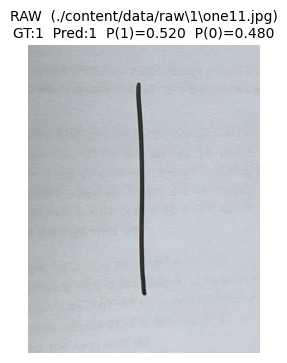

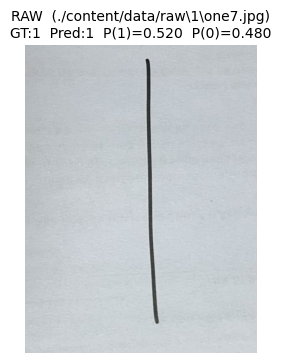

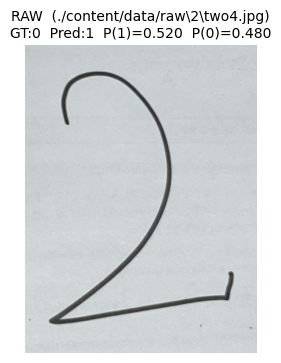

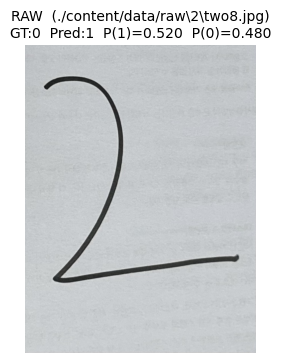

=== Evaluation Metrics (Pure Python) ===
Accuracy : 0.5000


In [ ]:
evaluate_and_show_test_raw(w_gd, b_gd, Xte, yte, names_te, thr=0.5)